In [1]:
#Importiamo le librerie utili
import time
import numpy as np
import scipy.stats
from scipy.integrate import odeint
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
%matplotlib inline
%precision 2

import elfi

#Prendiamo un seed arbitrario per riproducibilità dei risultati
seed = 19030815 
np.random.seed(seed)

#Input, tempo e condizioni iniziali
g=9.81
t0=0
t1=20 #20s
t=np.linspace(t0,t1,240)
th_0=[0,3] #Angolo e velocità angolare al tempo 0

In [2]:
#Definiamo il modello
def fun(th,t,g,l):
    th_1=th[0]
    th_2=th[1]
    dth_1=th_2
    dth_2=-g/l*np.sin(th_1)
    dth=[dth_1,dth_2]
    return dth

def pd(g,l,th_0,t,fun,n_obs=10,batch_size=1,random_state=None):
    th=odeint(fun,th_0,t,args=(g,l))
    n0=np.random.normal(loc=0,scale=0.05,size=len(th))
    n1=np.random.normal(loc=0,scale=0.1,size=len(th))
    th_noise=[th[:,0]+n0,th[:,1]+n1] #Aggiunta rumore gaussiano
    return th_noise[0] #Ritorniamo solo la velocità angolare (possibile causa outlier)

In [3]:
#Valori ottenuti con l=3
obs=pd(g,3,th_0,t,fun)
obs

array([-0.02,  0.29,  0.55,  0.65,  0.99,  1.19,  1.26,  1.44,  1.69,
        1.72,  1.8 ,  1.93,  1.79,  1.93,  1.95,  1.9 ,  1.97,  1.8 ,
        1.65,  1.59,  1.65,  1.35,  1.16,  0.96,  0.81,  0.5 ,  0.3 ,
        0.11, -0.12, -0.33, -0.72, -0.91, -1.15, -1.29, -1.37, -1.61,
       -1.73, -1.82, -1.85, -1.91, -1.86, -1.92, -1.96, -1.87, -1.93,
       -1.79, -1.61, -1.63, -1.47, -1.22, -0.94, -0.77, -0.6 , -0.38,
       -0.23,  0.16,  0.3 ,  0.63,  0.93,  1.09,  1.3 ,  1.39,  1.55,
        1.64,  1.83,  1.92,  1.93,  1.93,  1.9 ,  1.95,  1.96,  1.82,
        1.75,  1.75,  1.58,  1.33,  1.3 ,  1.11,  0.86,  0.66,  0.38,
        0.12, -0.02, -0.31, -0.5 , -0.81, -1.06, -1.22, -1.45, -1.56,
       -1.67, -1.75, -1.87, -1.97, -2.04, -1.94, -1.91, -1.88, -1.96,
       -1.78, -1.74, -1.54, -1.5 , -1.29, -1.14, -1.01, -0.75, -0.5 ,
       -0.26,  0.06,  0.31,  0.54,  0.77,  1.05,  1.28,  1.37,  1.5 ,
        1.52,  1.75,  1.88,  1.81,  1.84,  2.03,  1.87,  2.02,  1.9 ,
        1.89,  1.75,

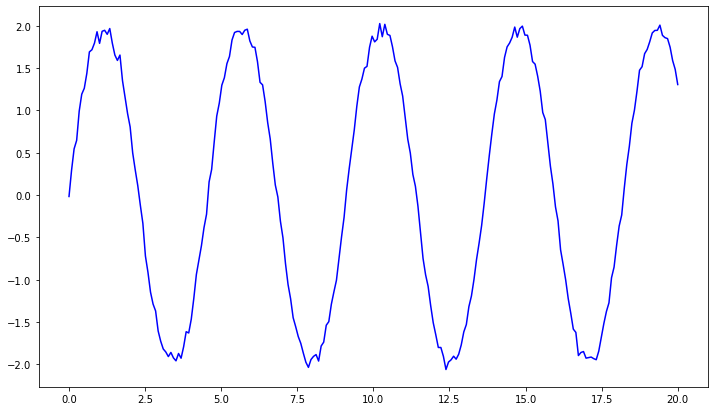

In [4]:
#Velocità angolare in funzione del tempo, con rumore gaussiano
plt.figure(figsize=(12,7))
plt.plot(t,obs,'b-')
plt.show()

In [5]:
#Settiamo una priori uniforme (abbastanza ampia e quindi poco informativa) per l
l=elfi.Prior(scipy.stats.uniform,0,7)

In [6]:
#Definiamo il nodo simulatore di elfi, basato su prior e modello
Y=elfi.Simulator(pd,g,l,th_0,t,fun,observed=obs)

In [7]:
def autocov(x, lag = 1):
    C = np.mean(x[lag:] * x[:-lag])
    return C

In [8]:
#Definiamo i nodi summary di elfi
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)

In [9]:
#Concludiamo il modello con la definizione euclidea di distanza
d = elfi.Distance('euclidean', S1, S2)

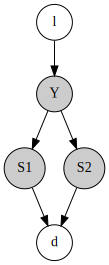

In [10]:
#Controlliamo tramite l'utilizzo di Graphviz la corretta struttura dei nodi scelti
elfi.draw(d)

In [11]:
#Sequential Monte Carlo
smc = elfi.SMC(d, batch_size=1, seed=seed)

In [12]:
schedule = [0.5, 0.05, 0.005]
%time result_smc = smc.sample(1000, schedule)

INFO:elfi.methods.inference.samplers:---------------- Starting round 0 ----------------
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


ABC-SMC Round 1 / 3


INFO:elfi.methods.inference.samplers:---------------- Starting round 1 ----------------


Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 3


INFO:elfi.methods.inference.samplers:---------------- Starting round 2 ----------------


Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 3
Progress [==================================================] 100.0% Complete
Wall time: 8min 11s


In [13]:
result_smc.summary(all=True)

Method: SMC
Number of samples: 1000
Number of simulations: 38345
Threshold: 0.005
Sample means: l: 3

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 10317
Threshold: 0.5
Sample means: l: 2.99

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 12820
Threshold: 0.05
Sample means: l: 3.01

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 15208
Threshold: 0.005
Sample means: l: 3


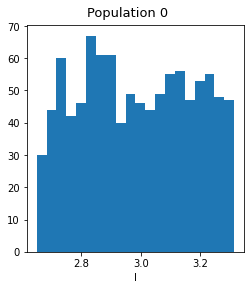

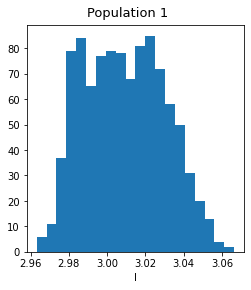

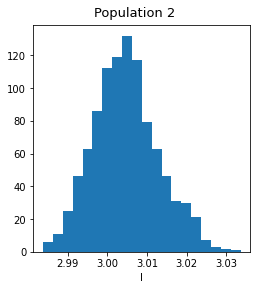

In [14]:
result_smc.plot_marginals(all=True)

In [15]:
#I risultati sono in linea con quello che ci aspettiamo, con un miglioramento più netto
#associato ad una threshold più stretta.